Retrieves images from "full_imgs" and stores each VOI separately in "train_imgs". Retrieves spreadsheet listing VOIs and stores them in text file. Requires data-retrieval to be run first.

In [142]:
import config
import helper_fxns as hf
import transforms as tr
import importlib
import numpy as np
import os
import requests
import sys
import copy
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

with open("train_list.txt", "r") as f:
    vois = [x.split(',') for x in f.read().split("\n")]

voi_df = pd.DataFrame(vois, columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls"]).dropna()
voi_df = voi_df.astype({"x1": int, "x2": int, "y1": int, "y2": int, "z1": int, "z2": int})

voi_df['dx'] = voi_df.apply(lambda row: row['x2'] - row['x1'], axis=1)
voi_df['dy'] = voi_df.apply(lambda row: row['y2'] - row['y1'], axis=1)
voi_df['dz'] = voi_df.apply(lambda row: row['z2'] - row['z1'], axis=1)

In [149]:
importlib.reload(config)
importlib.reload(hf)

<module 'helper_fxns' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\helper_fxns.py'>

In [150]:
C = config.Config()
final_size = C.dims

voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)

In [13]:
#voi_df = voi_df[~voi_df['cls'].isin(['colorectal', 'adenoma', 'fnh'])]
#set(voi_df['cls'].values)

In [146]:
def extract_voi(img, voi, min_dims, ven_voi=[], eq_voi=[]):
    """Input: image, a voi to center on, and the min dims of the unaugmented img.
    Outputs voi-centered image and classes.
    """
    
    voi_imgs = []
    classes = []
    temp_img = copy.deepcopy(img)
    
    x1 = voi['x1']
    x2 = voi['x2']
    y1 = voi['y1']
    y2 = voi['y2']
    z1 = voi['z1']
    z2 = voi['z2']
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    # align all phases
    if len(ven_voi) > 0:
        ven_voi = ven_voi.iloc[0]
        temp_img = hf.align(temp_img, voi, ven_voi, 1)
        
    if len(eq_voi) > 0:
        eq_voi = eq_voi.iloc[0]
        temp_img = hf.align(temp_img, voi, eq_voi, 2)

    #pad if voi is too close to edge
    buffer = math.sqrt(2) / .8
    xpad = max(min_dims[0] - dx, 0) * buffer
    ypad = max(min_dims[1] - dy, 0) * buffer
    zpad = max(min_dims[2] - dz, 0) * buffer
    side_padding = math.ceil(max(xpad, ypad, zpad) / 2)
    pad_img = []
    for ch in range(temp_img.shape[-1]):
        pad_img.append(np.pad(temp_img[:,:,:,ch], side_padding, 'constant'))
    pad_img = np.stack(pad_img, axis=3)
    
    #choice of ceil/floor needed to make total padding amount correct
    x1 += side_padding - math.ceil(xpad/2)
    x2 += side_padding + math.floor(xpad/2)
    y1 += side_padding - math.ceil(ypad/2)
    y2 += side_padding + math.floor(ypad/2)
    z1 += side_padding - math.ceil(zpad/2)
    z2 += side_padding + math.floor(zpad/2)
    
    new_voi = [voi['x1'] - x1, voi['x2'] - x1,
               voi['y1'] - y1, voi['y2'] - y1,
               voi['z1'] - z1, voi['z2'] - z1]

    pad_img = pad_img[x1:x2, y1:y2, z1:z2, :]
        
    return pad_img, voi['cls'], new_voi

In [147]:
def resize_img(img, final_dims, voi):
    """For rescaling an img to final_dims while scaling to make sure the image contains the voi."""
    
    x1 = voi[0]
    x2 = voi[1]
    y1 = voi[2]
    y2 = voi[3]
    z1 = voi[4]
    z2 = voi[5]
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    scale_ratio = max(final_dims[0]/dx, final_dims[1]/dy, final_dims[2]/dz)*0.9
    
    if scale_ratio < 0.9: #need to shrink original image to fit
        img = tr.scale3d(img, [scale_ratio]*3)
    elif scale_ratio > 1.4: #need to enlarge original image
        img = tr.scale3d(img, [scale_ratio]*3)
    
    crop = [img.shape[i] - final_dims[i] for i in range(3)]
    
    return img[crop[0]//2:-crop[0]//2, crop[1]//2:-crop[1]//2, crop[2]//2:-crop[2]//2, :]

In [148]:
def augment_img(img, final_dims, voi, num_samples, translate=None):
    """For rescaling an img to final_dims while scaling to make sure the image contains the voi."""
    
    x1 = voi[0]
    x2 = voi[1]
    y1 = voi[2]
    y2 = voi[3]
    z1 = voi[4]
    z2 = voi[5]
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    scale_ratio = max(final_dims[0]/dx, final_dims[1]/dy, final_dims[2]/dz)*0.9
    scales = [scale_ratio*0.8, scale_ratio]

    aug_imgs = []
    
    for _ in range(num_samples):
        angle = random.randint(0, 359)
        temp_img = tr.rotate(img, angle)
        
        if translate is not None:
            trans = [random.randint(-translate[0], translate[0]),
                     random.randint(-translate[1], translate[1]),
                     random.randint(-translate[2], translate[2])]
        else:
            trans = [0,0,0]
        
        flip = [random.choice([-1, 1]), random.choice([-1, 1]), random.choice([-1, 1])]

        scale = [random.uniform(scales[0],scales[1]), random.uniform(scales[0],scales[1]), random.uniform(scales[0],scales[1])]

        crops = [img.shape[i] - final_dims[i] for i in range(3)]

        #temp_img = add_noise(temp_img)

        temp_img = temp_img[crops[0]//2 *flip[0] + trans[0] : -crops[0]//2 *flip[0] + trans[0] : flip[0],
                            crops[1]//2 *flip[1] + trans[1] : -crops[1]//2 *flip[1] + trans[1] : flip[1],
                            crops[2]//2 *flip[2] + trans[2] : -crops[2]//2 *flip[2] + trans[2] : flip[2], :]
        
        aug_imgs.append(temp_img)
    
    return aug_imgs

In [161]:
classes_to_include = ['cyst', 'hcc', 'hemangioma', 'cholangio']#, 'fnh', 'colorectal']

voi_df_ven["id"] = str(voi_df_ven["id"])
voi_df_eq["id"] = str(voi_df_eq["id"])

"""if os.path.exists(C.aug_dir):
    print("Warning: path", C.aug_dir, "already exists.")
else:
    os.makedirs(C.aug_dir)"""
if not os.path.exists(C.orig_dir):
    os.makedirs(C.orig_dir)
if not os.path.exists(C.aug_dir):
    os.makedirs(C.aug_dir)
if not os.path.exists(C.crops_dir):
        os.makedirs(C.crops_dir)
    
for cls in classes_to_include:
    if not os.path.exists(C.orig_dir + cls):
        os.makedirs(C.orig_dir + cls)
    if not os.path.exists(C.aug_dir + cls):
        os.makedirs(C.aug_dir + cls)
    if not os.path.exists(C.crops_dir + cls):
        os.makedirs(C.crops_dir + cls)

In [166]:
img = np.load(C.full_img_dir+"\\"+img_fn)

In [167]:
img.shape

(256, 192, 44, 3)

In [157]:
def extract_vois(acc_nums, small_vois):
    """Call extract_voi for a list of acc_nums"""
    
    t = time.time()

    # iterate over image series
    for img_fn in acc_nums:
        img = np.load(C.full_img_dir+"\\"+img_fn)
        art_vois = voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"].isin(classes_to_include))]

        # iterate over each voi in that image
        for voi_num, voi in enumerate(art_vois.iterrows()):
            ven_voi = voi_df_ven[voi_df_ven["id"] == voi[1]["id"]]
            eq_voi = voi_df_eq[voi_df_eq["id"] == voi[1]["id"]]

            cropped_img, cls, small_voi = extract_voi(img, copy.deepcopy(voi[1]), final_size, ven_voi=ven_voi, eq_voi=eq_voi)
            fn = img_fn[:-4] + "_" + str(voi_num)
            np.save(C.crops_dir + cls + "\\" + fn, cropped_img)
            small_vois[fn] = small_voi

            if voi_num % 20 == 0:
                print(".", end="")
    print("")
    print(time.time()-t)
    
    return small_vois

In [158]:
small_vois = {}
small_vois = extract_vois(os.listdir(C.full_img_dir), small_vois)

.............................................................................................................................................................
254.85865020751953


In [159]:
t = time.time()

for cls in os.listdir(C.crops_dir):
    for fn in os.listdir(C.crops_dir + cls):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        unaug_img = resize_img(img, C.dims, small_vois[fn[:-4]])
        np.save(C.orig_dir + cls + "\\" + fn, unaug_img)
        
print(time.time()-t)

5.7312188148498535


In [162]:
t = time.time()

for cls in os.listdir(C.crops_dir):
    for file_num, fn in enumerate(os.listdir(C.crops_dir + cls)):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        aug_img = augment_img(img, C.dims, small_vois[fn[:-4]], num_samples=5, translate=[1,1,0])
        for x, sample in enumerate(aug_img):
            np.save(C.aug_dir + cls + "\\" + fn[:-4] + "_" + str(x), sample)
            
        if file_num % 30 == 0:
            print(".", end="")
            
print("")
print(time.time()-t)

..........
11.087590456008911


In [136]:
importlib.reload(hf)

<module 'helper_fxns' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\helper_fxns.py'>

In [164]:
cls = "cyst"
accnum = "12042703"
img = np.load(C.aug_dir + cls + "\\" + accnum + "_0_0.npy")
hf.plot_section_auto(img)

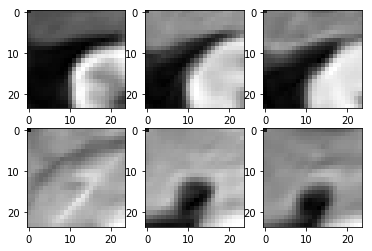

In [141]:
hf.plot_section_scan(img, 0.7)

img_fn = "E100529980.npy"
img = np.load(C.full_img_dir+"\\"+img_fn)
hf.plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=0)
#art_vois = voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"].isin(classes_to_include))]

#img = np.load("orig_imgs\\cyst\\E100529980_1.npy")
#plt.imshow(img[:,:,5,0], cmap='gray')

hf.augment(pad_img, C.dims, translate=[1,1,0], exceed_ratio=0.9, num_samples=1)